In [129]:
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_18131/3954667739.py:9: RuntimeWarning: divide by zero encountered in log
  lmdb = np.log(t)/10 + 1 #lambda scaling of x


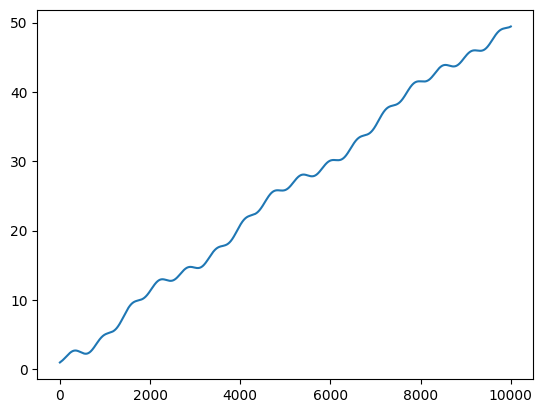

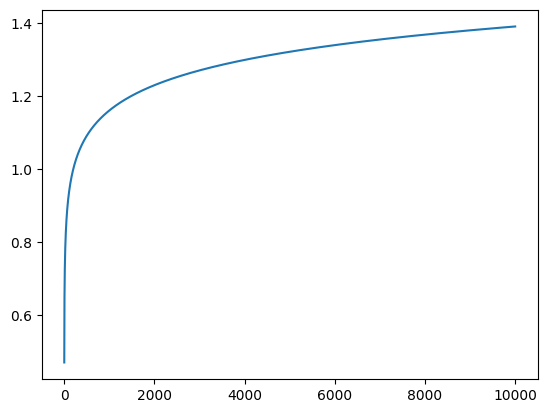

In [130]:
# generate a 1d path
t = np.linspace(0, 50, 10000)
dt = t[1]-t[0]
x = np.sin(t)**2 + np.cos(t**.8) + t
vel = np.gradient(x, dt, edge_order=2)
acc = np.gradient(vel, dt, edge_order=2)
plt.plot(x)
plt.figure()
lmdb = np.log(t)/10 + 1 #lambda scaling of x
plt.plot(lmdb)

In [131]:
# # scale x by lambda
# x_meas = x*lmdb
# plt.plot(x_meas)

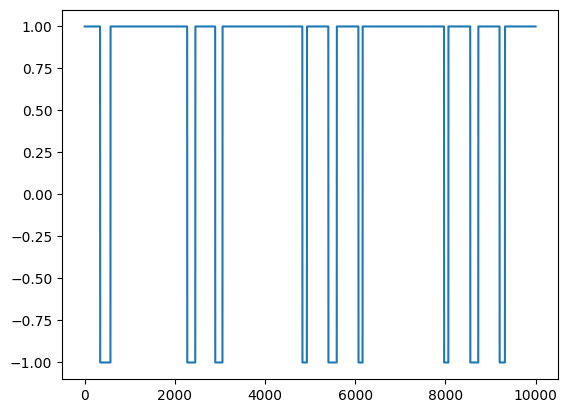

In [132]:
delta_x = np.gradient(x, 1)
# nomalize delta_x to 1 if positive, -1 if negative
delta_x_direction = delta_x/np.abs(delta_x)
plt.plot(delta_x_direction)

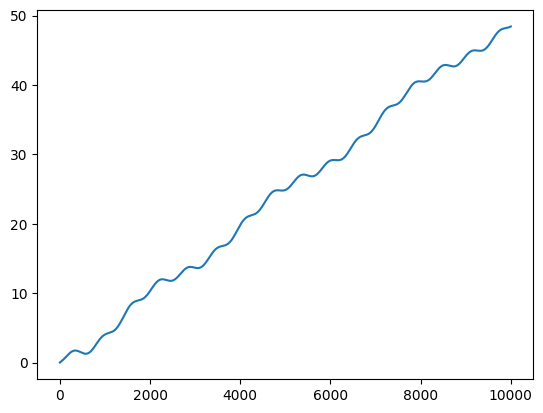

In [133]:
delta_x
# integrate delta_x
x_int = np.cumsum(delta_x)
plt.plot(x_int)

In [141]:
delta_x[-1]

0.0038489334768740946

In [152]:
# kalman filter
# state = [x,v,a,lambda]

# x state transition xk1 = xk + (v*dt)/lambda + (1/2*a*dt^2)/lambda
# v state transition vk1 = vk + a*dt/lambda
# a state transition ak1 = ak
# lambda state transition lambda_k1 = lambda_k
# state transition matrix

def get_F(state):
    F = np.array([[1, dt/state[3], (dt**2)/(2*state[3]), 0],
                  [0, 1, dt/state[3], 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return F


def nonlin_f(state):
    f = np.array([state[0] + (state[1]*dt)/state[3] + (state[2]*dt**2)/(2*state[3]),
                  state[1] + (state[2]*dt)/state[3],
                  state[2],
                  state[3]])
    return f

# measurements are
# z1 = xk/lambda
# z2 = a


def nonlin_h(state):
    h = np.array([state[0]/state[3],
                  state[2]])
    return h


def get_H(state):
    H = np.array([[1/state[3], 0, 0, -1/state[3]**2],
                  [0, 0, 1, 0]])
    return H


# EKF
# initialize state
state = np.array([x[0], vel[0], acc[0], delta_x_direction[0]])
# initialize covariance
P = np.eye(4)
# initialize measurement noise
R = np.eye(2)*0.001
# initialize process noise
Q = np.eye(4)

# run filter
state_hist = []
for i in range(len(x)):
    # predict
    state = nonlin_f(state)
    F = get_F(state)
    P = F @ P @ F.T + Q
    # update
    H = get_H(state)
    K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
    z = np.array([delta_x_direction[i], acc[i]])
    state = state + K @ (z - nonlin_h(state))
    P = (np.eye(4) - K @ H) @ P
    state_hist.append(state)
state_hist[-20:], P

([array([1.95328229e+03, 1.04132155e+02, 1.59062677e+00, 1.95334083e+03]),
  array([1.95328349e+03, 1.04132182e+02, 1.60356712e+00, 1.95334083e+03]),
  array([1.95328467e+03, 1.04132209e+02, 1.61635563e+00, 1.95334083e+03]),
  array([1.95328584e+03, 1.04132235e+02, 1.62899100e+00, 1.95334083e+03]),
  array([1.95328698e+03, 1.04132261e+02, 1.64147195e+00, 1.95334083e+03]),
  array([1.95328811e+03, 1.04132287e+02, 1.65379721e+00, 1.95334083e+03]),
  array([1.95328922e+03, 1.04132312e+02, 1.66596553e+00, 1.95334083e+03]),
  array([1.95329031e+03, 1.04132337e+02, 1.67797567e+00, 1.95334083e+03]),
  array([1.95329138e+03, 1.04132361e+02, 1.68982642e+00, 1.95334083e+03]),
  array([1.95329244e+03, 1.04132385e+02, 1.70151657e+00, 1.95334083e+03]),
  array([1.95329348e+03, 1.04132408e+02, 1.71304494e+00, 1.95334083e+03]),
  array([1.95329450e+03, 1.04132432e+02, 1.72441034e+00, 1.95334083e+03]),
  array([1.95329551e+03, 1.04132454e+02, 1.73561164e+00, 1.95334082e+03]),
  array([1.95329650e+03, 

In [136]:
state_hist

[array([ 1.00248171,  0.97690613, -2.59986419,  0.99755465]),
 array([ 1.00653219,  0.96561262, -2.27981286,  0.99582873]),
 array([ 1.01143387,  0.95558933, -1.88626358,  0.9930335 ]),
 array([ 1.01799572,  0.94575473, -1.47875345,  0.98832732]),
 array([ 1.02758701,  0.93483324, -1.13356607,  0.98038418]),
 array([ 1.04236372,  0.92307483, -0.84314086,  0.96722972]),
 array([ 1.06475665,  0.9118561 , -0.59798589,  0.94684681]),
 array([ 1.09444191,  0.90360356, -0.39052952,  0.9201845 ]),
 array([ 1.12505076,  0.8998803 , -0.21467459,  0.89389152]),
 array([ 1.15072311,  0.8993842 , -0.06533958,  0.87334986]),
 array([1.17162054, 0.90018536, 0.06178086, 0.85786983]),
 array([1.18953364, 0.90128818, 0.17033993, 0.84542507]),
 array([1.20556713, 0.9022352 , 0.26341984, 0.83481182]),
 array([1.22025658, 0.90277163, 0.34360099, 0.82543738]),
 array([1.23385936, 0.90273407, 0.41302779, 0.81700227]),
 array([1.24650155, 0.90201   , 0.47347177, 0.80934505]),
 array([1.25824263, 0.90051719, 

In [137]:
# integrate acc over 7 samples
p = 0
v = 0
for i in range(int(1/dt)):
    p = p + v*dt
    v = v + acc[i]*dt
p

0.24878105278697527

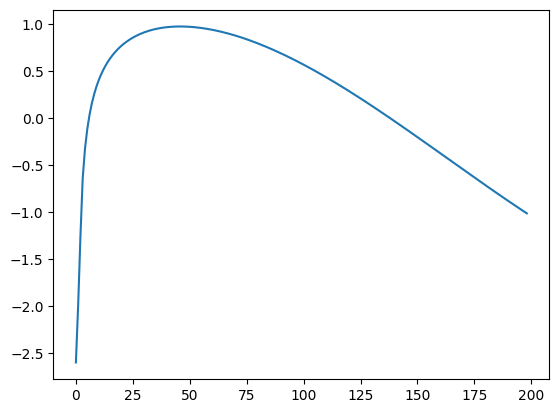

In [138]:
plt.plot(acc[:int(1/dt)])